<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span><ul class="toc-item"><li><span><a href="#Cтационарность-ряда" data-toc-modified-id="Cтационарность-ряда-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Cтационарность ряда</a></span></li><li><span><a href="#Декомпозиция-временного-ряда" data-toc-modified-id="Декомпозиция-временного-ряда-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Декомпозиция временного ряда</a></span><ul class="toc-item"><li><span><a href="#Тренд" data-toc-modified-id="Тренд-2.2.1"><span class="toc-item-num">2.2.1&nbsp;&nbsp;</span>Тренд</a></span></li></ul></li></ul></li><li><span><a href="#Обучение-моделей" data-toc-modified-id="Обучение-моделей-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение моделей</a></span><ul class="toc-item"><li><span><a href="#разделим-датасет-на-обучающую-и-тренировочную-выборки" data-toc-modified-id="разделим-датасет-на-обучающую-и-тренировочную-выборки-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>разделим датасет на обучающую и тренировочную выборки</a></span></li><li><span><a href="#LinearRegression" data-toc-modified-id="LinearRegression-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>LinearRegression</a></span></li><li><span><a href="#RandomForestRegressor" data-toc-modified-id="RandomForestRegressor-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>RandomForestRegressor</a></span></li><li><span><a href="#CatBoostRegressor" data-toc-modified-id="CatBoostRegressor-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>CatBoostRegressor</a></span></li><li><span><a href="#LightGMB" data-toc-modified-id="LightGMB-3.5"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>LightGMB</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
#библиотеки
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

In [2]:
df = pd.read_csv('/datasets/taxi.csv')

In [3]:
df

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32
...,...,...
26491,2018-08-31 23:10:00,32
26492,2018-08-31 23:20:00,24
26493,2018-08-31 23:30:00,27
26494,2018-08-31 23:40:00,39


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


In [5]:
df['datetime'] = pd.to_datetime(df['datetime'], format='%Y-%m-%d %H:%M:%S')

In [6]:
df.isna().sum()

datetime      0
num_orders    0
dtype: int64

In [7]:
df = df.set_index(df['datetime'])
df = df.drop('datetime', axis=1)
df

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
...,...
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27


In [8]:
df.sort_index(inplace=True)

In [9]:
df = df.resample('1H').sum()

<AxesSubplot:xlabel='datetime'>

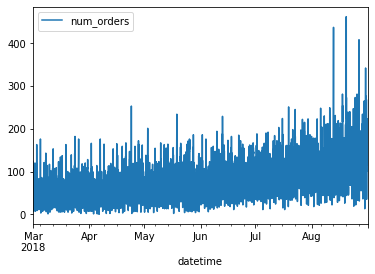

In [10]:
df.plot()

## Анализ

### Cтационарность ряда 

<AxesSubplot:xlabel='datetime'>

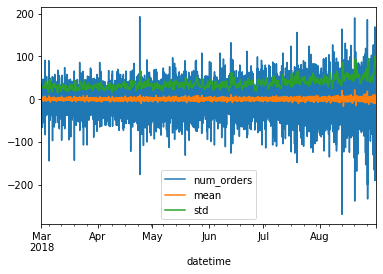

In [11]:
data = df - df.shift()
data['mean'] = data['num_orders'].rolling(20).mean()
data['std'] = data['num_orders'].rolling(20).std()
data.plot()

По графику видно что ряд достаточно стационарный. Т.е. распределение со временем не меняется, среднее и стандартное отклонение не меняются.

In [12]:
df.isna().sum()

num_orders    0
dtype: int64

### Декомпозиция временного ряда

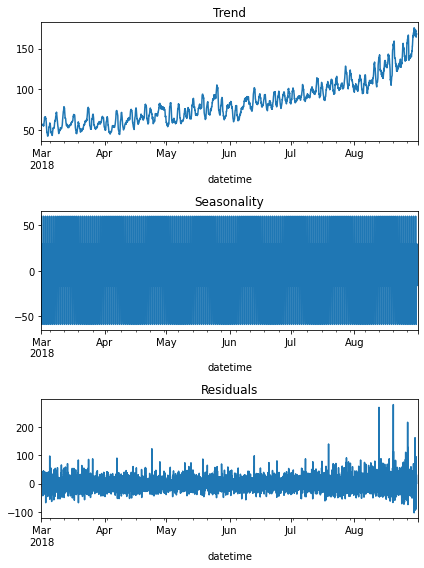

In [13]:
decomposed = seasonal_decompose(df)

plt.figure(figsize=(6, 8))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca()) 
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca()) 
plt.title('Residuals')
plt.tight_layout()

На графике тренд видно, что тренд постоянно растет с кадым месяем. Рассмотрим подробнее два последних месяца. 

#### Тренд

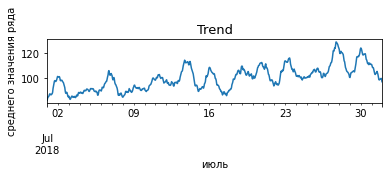

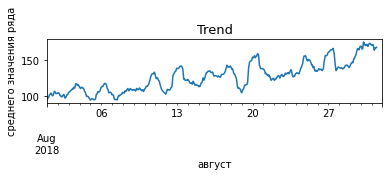

In [14]:
# по месяца
plt.subplot(311)
decomposed.trend['2018-07-01':'2018-07-31'].plot(ax=plt.gca())
plt.xlabel('июль', fontsize=10)
plt.ylabel('среднего значения ряда', fontsize=10)
plt.title('Trend', fontsize=13)
plt.show()

plt.subplot(312)
decomposed.trend['2018-08-01':'2018-08-31'].plot(ax=plt.gca())
plt.xlabel('август', fontsize=10)
plt.ylabel('среднего значения ряда', fontsize=10)
plt.title('Trend', fontsize=13)
plt.show()

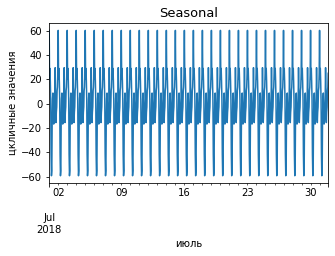

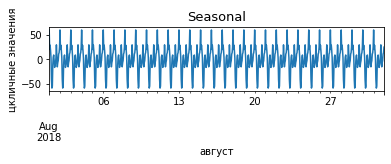

In [15]:
plt.figure(figsize=(5, 10))
plt.subplot(311)
decomposed.seasonal['2018-07-01':'2018-07-31'].plot(ax=plt.gca())
plt.xlabel('июль', fontsize=10)
plt.ylabel('цкличные значения', fontsize=10)
plt.title('Seasonal', fontsize=13)
plt.show()

plt.subplot(312)
decomposed.seasonal['2018-08-01':'2018-08-31'].plot(ax=plt.gca())
plt.xlabel('август', fontsize=10)
plt.ylabel('цкличные значения', fontsize=10)
plt.title('Seasonal', fontsize=13)
plt.show()

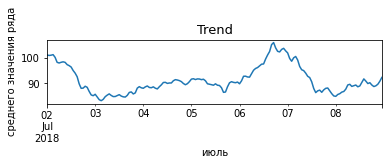

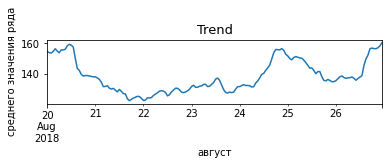

In [16]:
# на неделю
plt.subplot(311)
decomposed.trend['2018-07-02':'2018-07-08'].plot(ax=plt.gca())
plt.xlabel('июль', fontsize=10)
plt.ylabel('среднего значения ряда', fontsize=10)
plt.title('Trend', fontsize=13)
plt.show()

plt.subplot(312)
decomposed.trend['2018-08-20':'2018-08-26'].plot(ax=plt.gca())
plt.xlabel('август', fontsize=10)
plt.ylabel('среднего значения ряда', fontsize=10)
plt.title('Trend', fontsize=13)
plt.show()

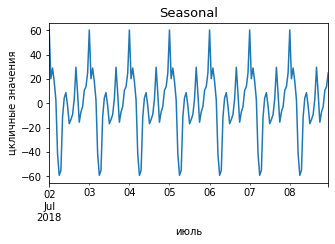

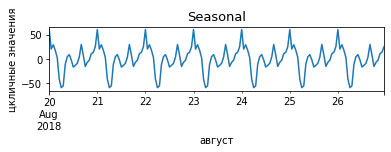

In [17]:
# на неделю
plt.figure(figsize=(5, 10))
plt.subplot(311)
decomposed.seasonal['2018-07-02':'2018-07-8'].plot(ax=plt.gca())
plt.xlabel('июль', fontsize=10)
plt.ylabel('цкличные значения', fontsize=10)
plt.title('Seasonal', fontsize=13)
plt.show()

plt.subplot(312)
decomposed.seasonal['2018-08-20':'2018-08-26'].plot(ax=plt.gca())
plt.xlabel('август', fontsize=10)
plt.ylabel('цкличные значения', fontsize=10)
plt.title('Seasonal', fontsize=13)
plt.show()

Посмотреть на сезонность за пару дней чтобы понять циклично повторяющиеся закономерности во временном ряду по времени, тоесть когда чаще заказывают такси а когда реже. 

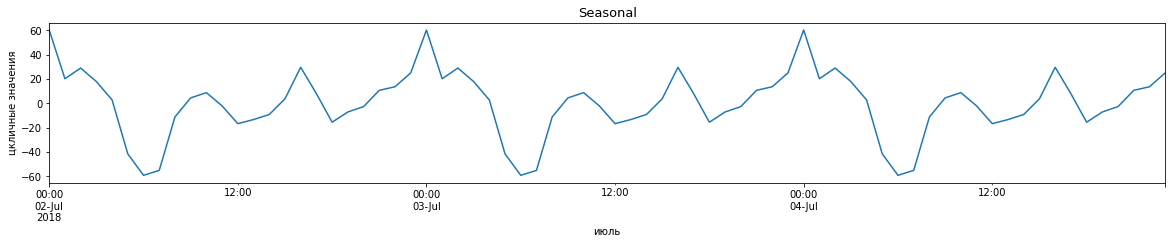

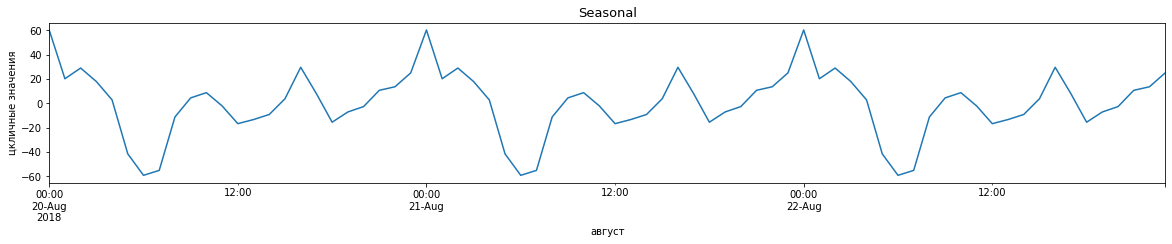

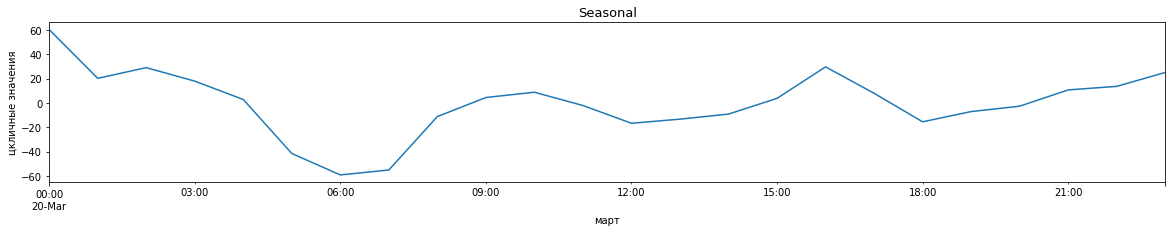

In [18]:
# на 2 дня
plt.figure(figsize=(20, 10))
plt.subplot(311)
decomposed.seasonal['2018-07-02':'2018-07-04'].plot(ax=plt.gca())
plt.xlabel('июль', fontsize=10)
plt.ylabel('цкличные значения', fontsize=10)
plt.title('Seasonal', fontsize=13)
plt.show()

plt.figure(figsize=(20, 10))
plt.subplot(312)
decomposed.seasonal['2018-08-20':'2018-08-22'].plot(ax=plt.gca())
plt.xlabel('август', fontsize=10)
plt.ylabel('цкличные значения', fontsize=10)
plt.title('Seasonal', fontsize=13)
plt.show()

plt.figure(figsize=(20, 10))
plt.subplot(312)
decomposed.seasonal['2018-03-20'].plot(ax=plt.gca())
plt.xlabel('март', fontsize=10)
plt.ylabel('цкличные значения', fontsize=10)
plt.title('Seasonal', fontsize=13)
plt.show()

Видно что сезонность с марта по июнь не сильно отличается если смотреть по дням, т.е самая низкая точка в 6 утра и раньше (ночь) - люди меньше всего заказывают такси, а начиная с 9 идет явный подъем, и час пик с 16-17- больше всего заказывают такси. 

## Обучение моделей

In [19]:
def make_features(df, max_lag, rolling_mean_size):
    df['day'] = df.index.day
    df['dayofweek'] = df.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)
    df['rolling_mean'] =df['num_orders'].shift().rolling(rolling_mean_size).mean()
    

In [20]:
make_features(df, 24, 4)

In [21]:
df = df.dropna()

In [22]:
df

,num_orders,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-02 00:00:00,90,2,4,58.0,113.0,66.0,61.0,45.0,73.0,44.0,...,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,124.0,74.50
2018-03-02 01:00:00,120,2,4,90.0,58.0,113.0,66.0,61.0,45.0,73.0,...,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,81.75
2018-03-02 02:00:00,75,2,4,120.0,90.0,58.0,113.0,66.0,61.0,45.0,...,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,95.25
2018-03-02 03:00:00,64,2,4,75.0,120.0,90.0,58.0,113.0,66.0,61.0,...,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,85.75
2018-03-02 04:00:00,20,2,4,64.0,75.0,120.0,90.0,58.0,113.0,66.0,...,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,87.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-31 19:00:00,136,31,4,207.0,217.0,197.0,116.0,133.0,166.0,136.0,...,99.0,230.0,194.0,276.0,246.0,158.0,198.0,142.0,72.0,184.25
2018-08-31 20:00:00,154,31,4,136.0,207.0,217.0,197.0,116.0,133.0,166.0,...,268.0,99.0,230.0,194.0,276.0,246.0,158.0,198.0,142.0,189.25
2018-08-31 21:00:00,159,31,4,154.0,136.0,207.0,217.0,197.0,116.0,133.0,...,78.0,268.0,99.0,230.0,194.0,276.0,246.0,158.0,198.0,178.50


### разделим датасет на обучающую и тренировочную выборки

In [23]:
train, test = train_test_split(df, shuffle=False, test_size=0.1)

features_train = train.drop(['num_orders'], axis=1)
features_test = test.drop(['num_orders'], axis=1)

target_train = train['num_orders']
target_test = test['num_orders']

In [24]:
print(features_train.shape)
print(features_test.shape)

(3952, 27)
(440, 27)


In [25]:
print(target_train.shape)
print(target_test.shape)

(3952,)
(440,)


### LinearRegression

Функция TimeSerieSplit принимает в качестве входных данных количество разделений. Поскольку наши данные обучения 1 год (2018), разделим по месяцам к нас их 5, мы должны установить n_splits = 5.

In [26]:
%%time
model_LR = LinearRegression()
tscv = TimeSeriesSplit(n_splits=5)
scores_LR = cross_val_score(model_LR,
                            features_train,
                            target_train,
                            cv=tscv,
                            verbose=3,
                            n_jobs=-1,
                            scoring='neg_root_mean_squared_error') 
RMSE_LR = (scores_LR * (-1)).mean()
print('RMSE для линейной регрессии:', RMSE_LR)

[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s


[CV] END .............................. score: (test=-24.794) total time=   0.1s
[CV] END .............................. score: (test=-24.480) total time=   0.1s
[CV] END .............................. score: (test=-25.654) total time=   0.2s
[CV] END .............................. score: (test=-27.503) total time=   0.3s
[CV] END .............................. score: (test=-33.606) total time=   0.0s
RMSE для линейной регрессии: 27.207554741240635
CPU times: user 344 ms, sys: 435 ms, total: 779 ms
Wall time: 669 ms


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.7s finished


### RandomForestRegressor

In [27]:
%%time
model_RFR = RandomForestRegressor(random_state=12345)
param_search = { 
    'n_estimators': [i for i in range(1,2, 1)],
    'max_depth' : [i for i in range(1,10, 1)]}

tscv = TimeSeriesSplit(n_splits=5)

gsearch_RFR = GridSearchCV(estimator=model_RFR, cv=tscv, param_grid=param_search, scoring = 'neg_root_mean_squared_error')
gsearch_RFR.fit(features_train, target_train)

best_score_RFR = gsearch_RFR.best_score_
best_model_RFR = gsearch_RFR.best_estimator_
print(-best_score_RFR)
print('-------------------')
print(best_model_RFR)
print('-------------------')
print(gsearch_RFR.best_params_)

30.684905329199704
-------------------
RandomForestRegressor(max_depth=4, n_estimators=1, random_state=12345)
-------------------
{'max_depth': 4, 'n_estimators': 1}
CPU times: user 711 ms, sys: 5.78 ms, total: 717 ms
Wall time: 715 ms


### CatBoostRegressor

In [ ]:
model_cat = CatBoostRegressor(random_state=12345)

grid = {'learning_rate': [0.03, 0.1],
        'depth': [4, 6, 10]}

tscv = TimeSeriesSplit(n_splits=5).split(features_train)
gsearch_cat = GridSearchCV(estimator=model_cat, cv=tscv, param_grid=grid, scoring = 'neg_root_mean_squared_error')
gsearch_cat.fit(features_train, target_train)

best_score_cat = gsearch_cat.best_score_
best_model_cat = gsearch_cat.best_estimator_
print(-best_score_cat)
print('-------------------')
print(best_model_cat)
print('-------------------')
print(gsearch_cat.best_params_)

0:	learn: 29.2557379	total: 47.8ms	remaining: 47.8s
1:	learn: 28.9226991	total: 49.3ms	remaining: 24.6s
2:	learn: 28.5526536	total: 50.6ms	remaining: 16.8s
3:	learn: 28.2220875	total: 51.9ms	remaining: 12.9s
4:	learn: 27.8888230	total: 53.1ms	remaining: 10.6s
5:	learn: 27.5683278	total: 54.3ms	remaining: 9s
6:	learn: 27.2518010	total: 55.5ms	remaining: 7.87s
7:	learn: 26.9545619	total: 56.9ms	remaining: 7.06s
8:	learn: 26.6858097	total: 58.1ms	remaining: 6.4s
9:	learn: 26.3790606	total: 59.4ms	remaining: 5.88s
10:	learn: 26.1088760	total: 60.5ms	remaining: 5.44s
11:	learn: 25.8344075	total: 61.7ms	remaining: 5.08s
12:	learn: 25.5807018	total: 63ms	remaining: 4.78s
13:	learn: 25.3298094	total: 64.2ms	remaining: 4.52s
14:	learn: 25.0870940	total: 65.6ms	remaining: 4.31s
15:	learn: 24.8909441	total: 66.8ms	remaining: 4.11s
16:	learn: 24.6832397	total: 67.9ms	remaining: 3.93s
17:	learn: 24.4397200	total: 69.1ms	remaining: 3.77s
18:	learn: 24.2422489	total: 70.5ms	remaining: 3.64s
19:	learn

### LightGMB

In [ ]:
%%time
model_LGBMR = LGBMRegressor(random_state=12345)

param_grid = {'n_estimators': [100, 500, 1000], 
              'num_leaves': [10, 20, 30],
              'max_depth': [i for i in range(5,20)],
             'max_lag': [24]}

tscv = TimeSeriesSplit(n_splits=5)

gsearch_LGBMR = GridSearchCV(estimator=model_LGBMR,
                             param_grid=param_grid,
                             scoring='neg_root_mean_squared_error',
                             cv=tscv)
gsearch_LGBMR.fit(features_train, target_train)

print(-gsearch_LGBMR.best_score_)
print('-------------------')
print(gsearch_LGBMR.best_estimator_)
print('-------------------')
print(gsearch_LGBMR.best_params_)

Лучшая модель CatBoostRegressor, протестируем ее на тестовой выборке. 

## Тестирование

In [31]:
best_model_cat = CatBoostRegressor(random_state=12345, learning_rate=0.03, max_depth=6)
best_model_cat.fit(features_train, target_train)
predict_cat= best_model_cat.predict(features_test)
RMSE_cat = mean_squared_error(target_test, predict_cat) ** 0.5
print("RMSE_cat:", RMSE_cat)

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

0:	learn: 38.2102948	total: 6.23ms	remaining: 6.22s
1:	learn: 37.6829447	total: 12.3ms	remaining: 6.14s
2:	learn: 37.2112705	total: 18.5ms	remaining: 6.16s
3:	learn: 36.7315373	total: 24.7ms	remaining: 6.14s
4:	learn: 36.2757883	total: 30.9ms	remaining: 6.14s
5:	learn: 35.8229925	total: 36.9ms	remaining: 6.11s
6:	learn: 35.3995987	total: 43.4ms	remaining: 6.16s
7:	learn: 35.0158806	total: 50ms	remaining: 6.2s
8:	learn: 34.6401896	total: 55.7ms	remaining: 6.14s
9:	learn: 34.2366550	total: 61.8ms	remaining: 6.12s
10:	learn: 33.8697916	total: 67.7ms	remaining: 6.08s
11:	learn: 33.5215916	total: 73.6ms	remaining: 6.06s
12:	learn: 33.2009191	total: 79.7ms	remaining: 6.05s
13:	learn: 32.8659881	total: 86.1ms	remaining: 6.07s
14:	learn: 32.5451327	total: 92.5ms	remaining: 6.07s
15:	learn: 32.2704903	total: 98.5ms	remaining: 6.05s
16:	learn: 31.9870792	total: 104ms	remaining: 6.03s
17:	learn: 31.7005164	total: 110ms	remaining: 6s
18:	learn: 31.4520790	total: 116ms	remaining: 5.98s
19:	learn: 3

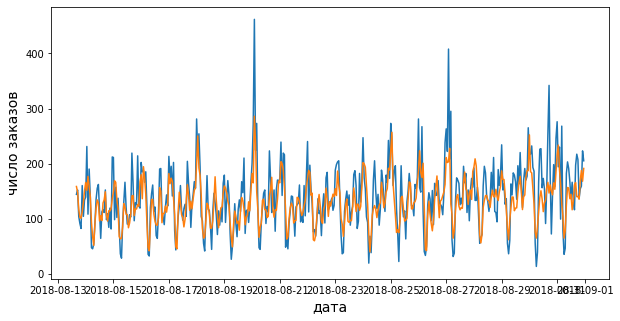

In [32]:
plt.figure(figsize=(10,5))
plt.plot(target_test)
plt.plot(pd.Series(predict_cat, index=target_test.index))
plt.xlabel('дата', fontsize=14)
plt.ylabel('число заказов',fontsize=14)
plt.show()

Результат на тестовой выборке 40. а графике выдно что предсказание в среднем почти похоже, единственное в точках максимума минимума не дотягивает. 

## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [ ]  Весь код выполняется без ошибок
- [ ]  Ячейки с кодом расположены в порядке исполнения
- [ ]  Данные загружены и подготовлены
- [ ]  Данные проанализированы
- [ ]  Модель обучена, гиперпараметры подобраны
- [ ]  Качество моделей проверено, выводы сделаны
- [ ]  Значение *RMSE* на тестовой выборке не больше 48